In [1]:
# prepare libs

import os
# from tqdm.autonotebook import tqdm, trange
from tqdm import tqdm, trange


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import PIL
print(PIL.__version__)
print ("all libs imported")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


9.5.0
all libs imported


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')


In [3]:
# get images
# !ls -la drive/MyDrive/Stepik_ML/pinocchio

# !unzip drive/MyDrive/Stepik_ML/pinocchio/journey-springfield.zip -d drive/MyDrive/Stepik_ML/pinocchio/images



In [2]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            self.classes = self.label_encoder.classes_


            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
#определим директории с тренировочными и тестовыми файлами
# PATH_TO_IMAGES = 'drive/MyDrive/Stepik_ML/pinocchio/images'
# TRAIN_DIR = Path(PATH_TO_IMAGES + '/train/')
# TEST_DIR = Path(PATH_TO_IMAGES + '/testset')

TRAIN_DIR = Path('../input/journey-springfield-zip/train/')
TEST_DIR = Path('../input/journey-springfield-zip/testset')

print(f'TRAIN_DIR is {TRAIN_DIR}')
print(f'TEST_DIR is {TEST_DIR}')


TRAIN_DIR is ../input/journey-springfield-zip/train
TEST_DIR is ../input/journey-springfield-zip/testset


In [6]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='val')

In [10]:
num_unique_labels = len(val_dataset.classes)
print(f"Количество уникальных меток в val_dataset: {num_unique_labels}")
num_unique_labels_train = len(train_dataset.classes)
print(f"Количество уникальных меток в train_dataset: {num_unique_labels_train}")


Количество уникальных меток в val_dataset: 42
Количество уникальных меток в train_dataset: 42


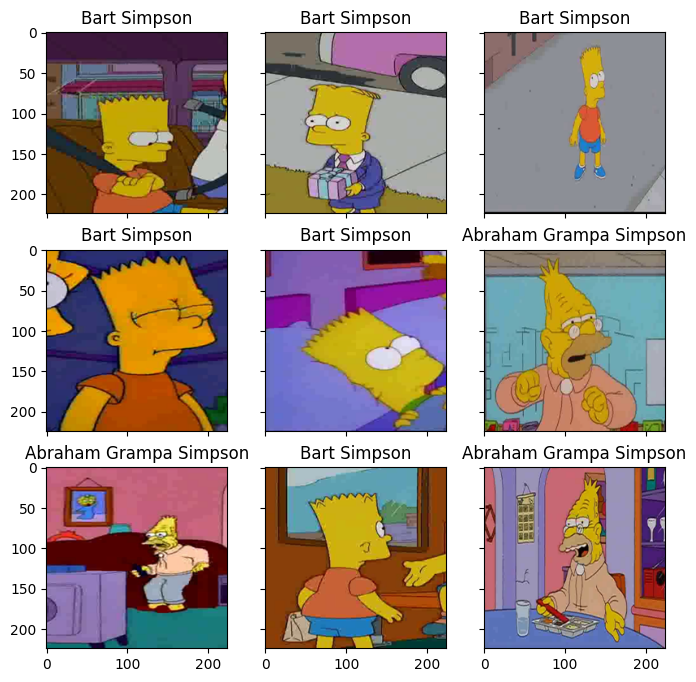

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [12]:
#функция для тренировки модели

use_gpu = torch.cuda.is_available()

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {
    'train': train_loader,
    'val': val_loader
    }
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

class_names = train_dataset.classes


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], 'val': []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:
        # Каждая эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Установить модель в режим обучения
            else:
                model.eval()   # Установить модель в режим оценки

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # Инициализируем градиенты параметров
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, -1)
                    loss = criterion(outputs, labels)

                    # Backward pass + оптимизация только если это стадия обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Обновление планировщика скорости обучения
            if phase == 'train':
                scheduler.step()

            # Запоминаем лучшие веса модели, если достигнуто лучшее качество на валидации
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses


In [14]:
# Функция для отрисовки тестовых изображений и предсказаний для них:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [15]:
# Функция для измерения точности модели на валидационном датасете
def evaluate(model):
    model.eval()

    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data

        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)

        runninig_correct += int(torch.sum(predicted == labels))

    return runninig_correct / dataset_sizes['val']

In [17]:
# импортируем AlexNet
# model = models.alexnet(pretrained=True)
# Если вам нужна последняя версия весов (если таковая имеется), 
# вы можете использовать AlexNet_Weights.DEFAULT. 
# Это обеспечит загрузку самой актуальной версии предобученных весов для данной модели.
from torchvision.models import alexnet, AlexNet_Weights
model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 61.8MB/s] 


In [19]:
# посмотрим, что внутри
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Fine Tuning способ**





Сконфигурируем - изменим FC-слой и зададим cost function и оптимизирующий алгоритм:

(по умолчанию backpropagation распространяется на все слои, поэтому здесь мы только заменяем FC-слой на свой классификатор)

In [20]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

val Loss: 0.1931 Acc: 0.9278: 100%|██████████| 25/25 [1:02:50<00:00, 150.83s/it]  

Training complete in 62m 51s
Best val Acc: 0.930073


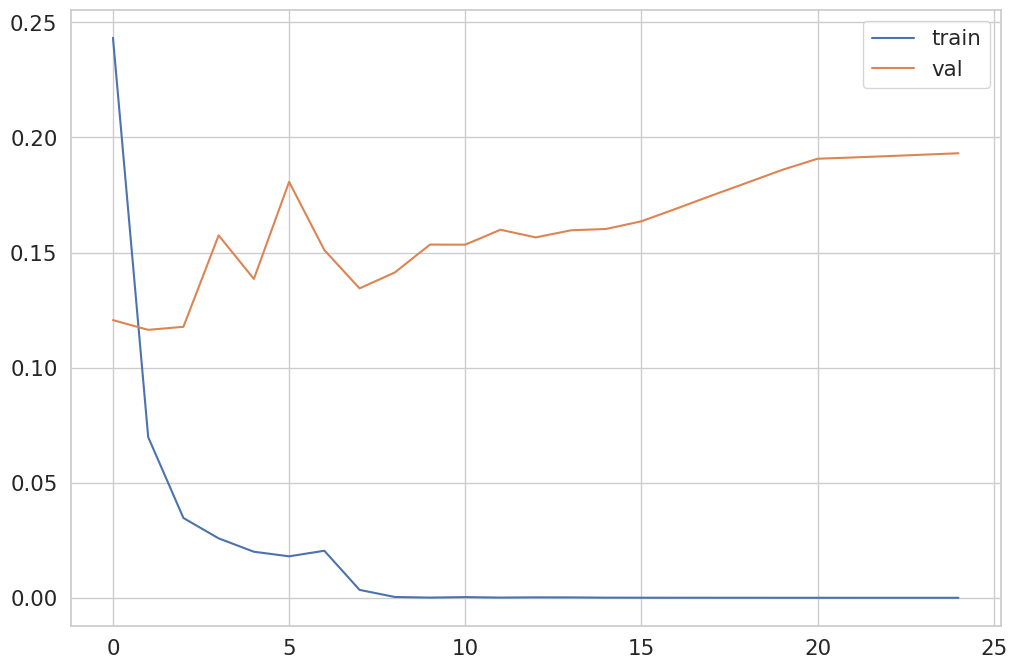

In [20]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [21]:
torch.save(model.state_dict(), 'AlexNet_fine_tune_2.pth')
print("success")

success


In [22]:
model.load_state_dict(torch.load('AlexNet_fine_tune_2.pth'))

<All keys matched successfully>

In [23]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.9278


In [28]:
!ls -la .

total 11184
drwxr-xr-x 3 root root     4096 Dec 18 08:55 .
drwxr-xr-x 5 root root     4096 Dec 18 07:24 ..
drwxr-xr-x 2 root root     4096 Dec 18 07:24 .virtual_documents
-rw-r--r-- 1 root root 11431693 Dec 18 08:55 AlexNet_extractor.pth
-rw-r--r-- 1 root root     4271 Dec 18 07:28 label_encoder.pkl


**Feature Extractor** способ:

In [21]:
from torchvision.models import alexnet, AlexNet_Weights

model_extractor = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

In [22]:
# Помним, что по-умолчанию все слои нейросети обучаются заново:
for param in model_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [24]:
# Сделаем так, чтобы на них не распространялся backpropagation (заморозим их), и подменим классификатор (ведь старый уже с весами для ImageNet'а).
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model_extractor.classifier.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [25]:
%%time
model_extractor,losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

val Loss: 0.2811 Acc: 0.8309: 100%|██████████| 25/25 [1:01:30<00:00, 147.61s/it]  

Training complete in 61m 30s
Best val Acc: 0.831677
CPU times: user 1h 52min 59s, sys: 1min 39s, total: 1h 54min 38s
Wall time: 1h 1min 30s


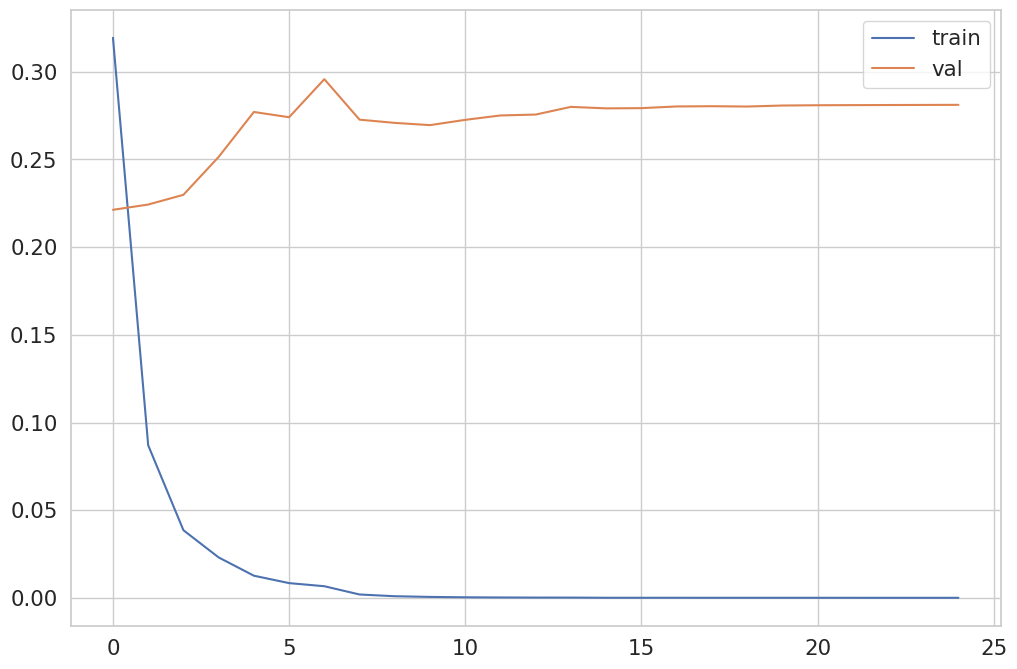

In [26]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [27]:
torch.save(model_extractor.state_dict(), 'AlexNet_extractor.pth')

In [29]:
model_extractor.load_state_dict(torch.load('AlexNet_extractor.pth'))

<All keys matched successfully>

In [30]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.8309


In [31]:
!ls -la .

total 11184
drwxr-xr-x 3 root root     4096 Dec 18 08:55 .
drwxr-xr-x 5 root root     4096 Dec 18 07:24 ..
drwxr-xr-x 2 root root     4096 Dec 18 07:24 .virtual_documents
-rw-r--r-- 1 root root 11431693 Dec 18 08:55 AlexNet_extractor.pth
-rw-r--r-- 1 root root     4271 Dec 18 07:28 label_encoder.pkl


Смешанный способ: Мы будем обучать не только последний fully connected слой, но и несколько предпоследних

In [17]:
from torchvision.models import alexnet, AlexNet_Weights

model_mixed = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

NameError: name 'alexnet' is not defined

In [33]:
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_mixed.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model_mixed = model_mixed.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [34]:
%%time
_, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

val Loss: 0.2557 Acc: 0.9169: 100%|██████████| 25/25 [1:04:40<00:00, 155.21s/it]  

Training complete in 64m 40s
Best val Acc: 0.917845
CPU times: user 1h 59min 10s, sys: 1min 44s, total: 2h 54s
Wall time: 1h 4min 40s


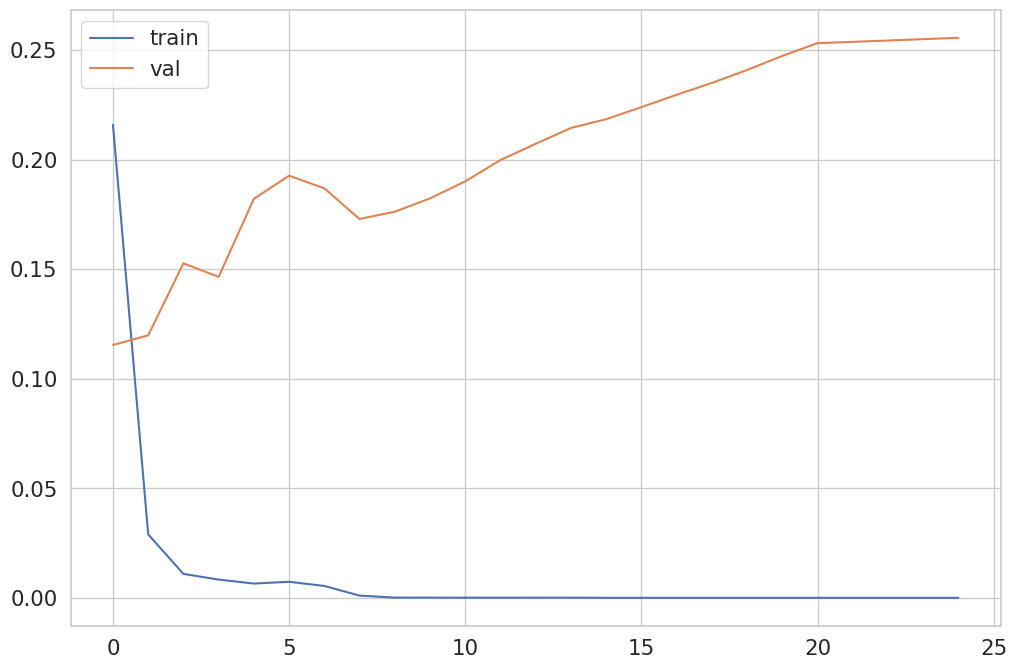

In [35]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [36]:
torch.save(model_mixed.state_dict(), 'AlexNet_mixed.pth')

In [37]:
model_mixed.load_state_dict(torch.load('AlexNet_mixed.pth'))

<All keys matched successfully>

In [38]:
print("Accuracy: {0:.4f}".format(evaluate(model_mixed)))

Accuracy: 0.9169


In [43]:
!ls -la .

total 22348
drwxr-xr-x 3 root root     4096 Dec 18 10:35 .
drwxr-xr-x 5 root root     4096 Dec 18 07:24 ..
drwxr-xr-x 2 root root     4096 Dec 18 07:24 .virtual_documents
-rw-r--r-- 1 root root 11431693 Dec 18 08:55 AlexNet_extractor.pth
-rw-r--r-- 1 root root 11431637 Dec 18 10:35 AlexNet_mixed.pth
-rw-r--r-- 1 root root     4271 Dec 18 07:28 label_encoder.pkl


In [44]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'AlexNet_mixed.pth'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")


/kaggle/working/AlexNet_mixed.pth

**Еще один способ**

Можно не замораживать все первые слои, а делать так, чтобы шаг градиента на них был меньше. Интерфейс оптимизатора позволяет это делать.

In [24]:
from torchvision.models import alexnet, AlexNet_Weights

num_features = 9216

model_diff_lr = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

model_diff_lr.classifier = nn.Linear(num_features, 42)

optimizer = torch.optim.Adam(params=[
        {"params": model_diff_lr.classifier.parameters()},
        {"params": model_diff_lr.features.parameters(), "lr": 1e-5,}
    ], 
    lr=1e-4
)

criterion = nn.CrossEntropyLoss()


# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [25]:
model_diff_lr.to("cuda")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)

In [27]:
_, losses = train_model(model_diff_lr, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

val Loss: 0.3455 Acc: 0.9012: 100%|██████████| 25/25 [1:00:49<00:00, 146.00s/it]  

Training complete in 60m 50s
Best val Acc: 0.901796


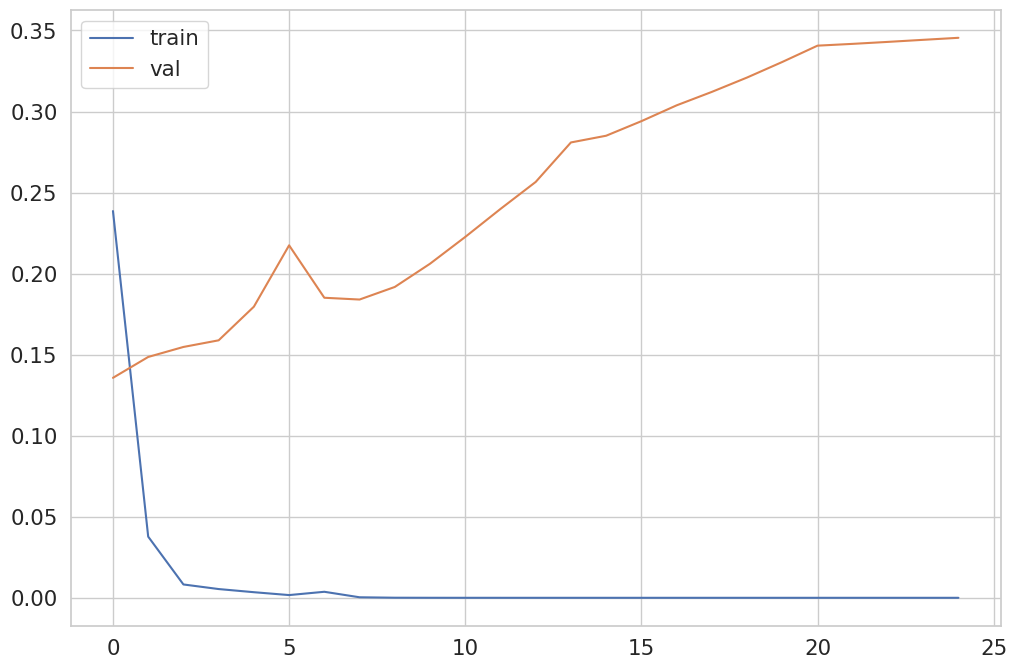

In [28]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [31]:
torch.save(model_diff_lr.state_dict(), 'AlexNet_diff.pth')

In [32]:
model_diff_lr.load_state_dict(torch.load('AlexNet_diff.pth'))

<All keys matched successfully>

In [33]:
print("Accuracy: {0:.4f}".format(evaluate(model_diff_lr)))

Accuracy: 0.9012


In [34]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'AlexNet_diff.pth'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")

/kaggle/working/AlexNet_diff.pth

**VGG16**

In [43]:
# Ваш код здесь
from torchvision import models
from torchvision.models import VGG16_Weights

model_extractor = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [44]:
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

val Loss: 1.0517 Acc: 0.7703: 100%|██████████| 25/25 [1:18:43<00:00, 188.95s/it]  

Training complete in 78m 44s
Best val Acc: 0.770539


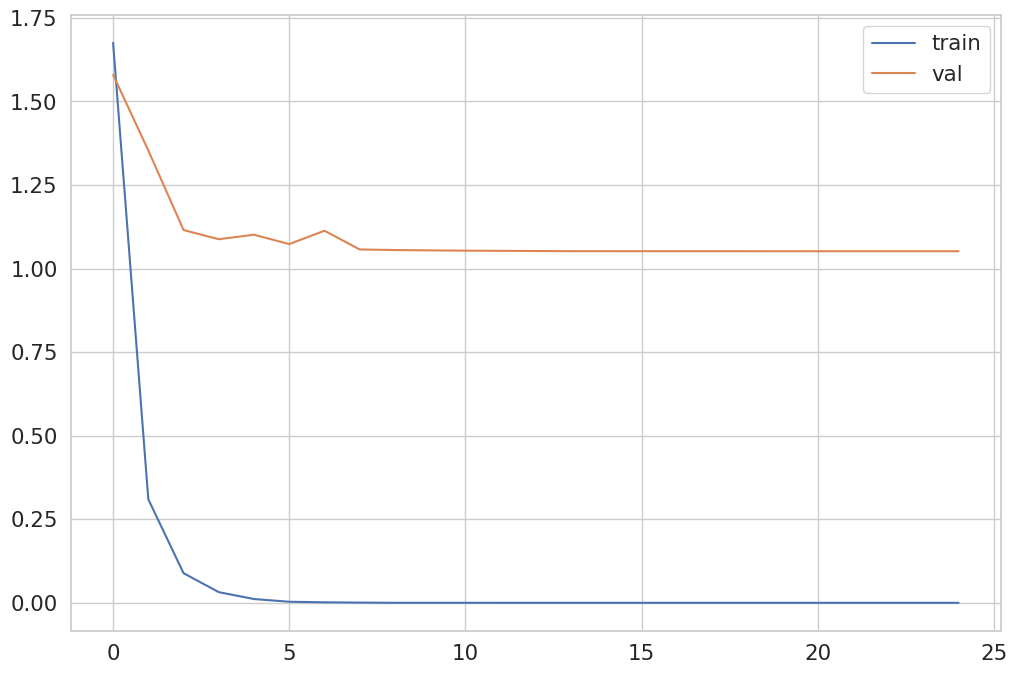

In [46]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [48]:
torch.save(model_extractor.state_dict(), 'VGG16.pth')

In [49]:
model_extractor.load_state_dict(torch.load('VGG16.pth'))

<All keys matched successfully>

In [50]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.7703


In [51]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'VGG16.pth'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")

/kaggle/working/VGG16.pth